# GARCH and Black Scholes Simulation

## Team Members:
1. Ahmik Virani - ES22BTECH11001
2. Prajjwal Prashant Lade - ES22BTECH11027
3. Dhawal Gupta - ES22BTECH11015
4. Gaurav Choudekar - CS22BTECH11015
5. Shreyas Wankhede - AI21BTECH11028

In [ ]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 8.4 MB/s eta 0:00:00


## We Begin with importing the necessary libraries

In [1]:
import numpy as np 
import pandas as pd  
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU, SimpleRNN
from keras.models import Sequential
from keras import optimizers
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from arch import arch_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, Input

plt.style.use('fivethirtyeight')

In [2]:
def plot_results(y_true, y_pred):
    import matplotlib.pyplot as plt
    plt.plot(y_true, label='True')
    plt.plot(y_pred, label='Predicted')
    plt.legend()
    plt.show()

In [3]:
def black_scholes(t, S, K, r, sigma):
    d1 = (np.log(S/K) + (r + ((sigma**2)/2))*t) / (sigma * np.sqrt(t))
    d2 = d1 - (sigma * np.sqrt(t))
    C = S * norm.cdf(d1) - K * np.exp(-r*t) * norm.cdf(d2)
    return C

In [4]:
# Data collection and preprosessing
# Here We load the data and caculate the returns

data = pd.read_csv('SBI_Historical_Data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

# Ensure that the data is sorted by date
data = data.sort_values('Date').reset_index(drop=True)
close_prices = data['Close']


returns = 100 * close_prices.pct_change().dropna()
data['returns'] = returns

In [5]:
# We will train the data on the first 90 time instances and use them to test on the remaining time instances

split_idx = int(len(returns) * 0.9)
returns_train = returns[:split_idx]
returns_test = returns[split_idx:]

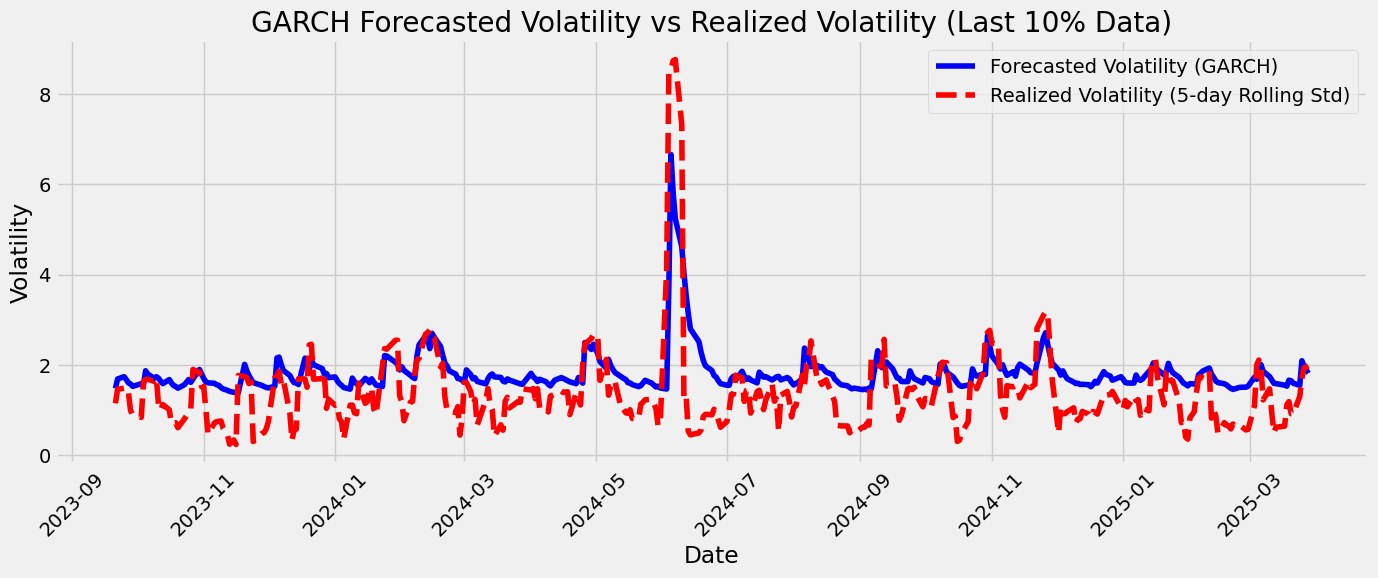

In [6]:
# We use the GARCH(1,1) model for this project
model = arch_model(returns_train, vol='Garch', p=1, q=1)
garch_fit = model.fit(disp="off")

forecast_horizon = len(returns_test)
forecast_volatility = []

# Compute the forecast volatility estimated by garch
for i in range(forecast_horizon):
    temp_train = returns[:split_idx + i]
    model = arch_model(temp_train, vol='Garch', p=1, q=1)
    garch_fit = model.fit(disp="off")

    forecast = garch_fit.forecast(horizon=1)
    var = forecast.variance.values[-1, 0]
    vol = np.sqrt(var)
    forecast_volatility.append(vol)

forecast_volatility = np.array(forecast_volatility)

# Calculate true realized volatility (rolling std of returns)
window_size = 5
volatility = returns.rolling(window=window_size).std()
true_train_volatility = volatility[:split_idx]
true_test_volatility = volatility[split_idx:]

# Graph plotted to compare forecast volatility by garch and true volatility found using rolling window method
plt.figure(figsize=(14,6))
plt.plot(data.loc[returns_test.index, 'Date'], forecast_volatility, label='Forecasted Volatility (GARCH)', color='blue')
plt.plot(data.loc[returns_test.index, 'Date'], true_test_volatility, label='Realized Volatility (5-day Rolling Std)', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('GARCH Forecasted Volatility vs Realized Volatility (Last 10% Data)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
# This cell is required to ensure that we get the data for the LSTM, RNN, GRU computations

def load_data(dataset, target_column, window_size, scale_labels=False):
    # Get the target series
    target = dataset[target_column].dropna().values

    features = []
    labels = []

    for i in range(window_size, len(target)):
        features.append(target[i-window_size:i])
        labels.append(target[i])

    features = np.array(features)
    labels = np.array(labels)

    # Split into train and test sets as mentioned before
    split_idx = int(len(features) * 0.9)

    feature_train = features[:split_idx]
    label_train = labels[:split_idx]
    feature_test = features[split_idx:]
    label_test = labels[split_idx:]

    # Optionally scale labels if required
    if scale_labels:
        label_train = label_train
        label_test = label_test

    return feature_train, label_train, feature_test, label_test

In [8]:
# We compute the errors of the GARCH model

garch_mse_error = mean_squared_error(true_test_volatility, forecast_volatility)
garch_mae_error = mean_absolute_error(true_test_volatility, forecast_volatility)

print(garch_mse_error, garch_mae_error)

0.6239092907487548 0.6039806678717095


In [9]:
# We now add the volatility as a column to our data

dataset = data
volatility = volatility
dataset['volatility'] = np.concatenate([[np.nan], volatility])

# Next we ensure that we change the index to Date
dataset = dataset.set_index('Date')
dataset = dataset.sort_index()

# We next ensure to collect the training and testing samples for the Deep Learning model
feature_train, label_train, feature_test, label_test = load_data(dataset, 'volatility', window_size, True)

In [10]:
# Since we are concerned with only the latest 10% testing data, we concatinate the remaining space with 0's and add garch predictions to out dataset

n_zeros = dataset.shape[0] - forecast_volatility.shape[0]
dummy = np.concatenate([np.zeros(n_zeros), forecast_volatility.flatten()])

dataset['garch_prediction'] = dummy

# LSTM

Epoch 1/5


/Users/ahmikvirani/.pyenv/versions/3.11.5/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 4.1805 - val_loss: 1.9966
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 2.4105 - val_loss: 1.0536
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.9955 - val_loss: 1.2886
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.0008 - val_loss: 0.9553
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.8045 - val_loss: 0.9441
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


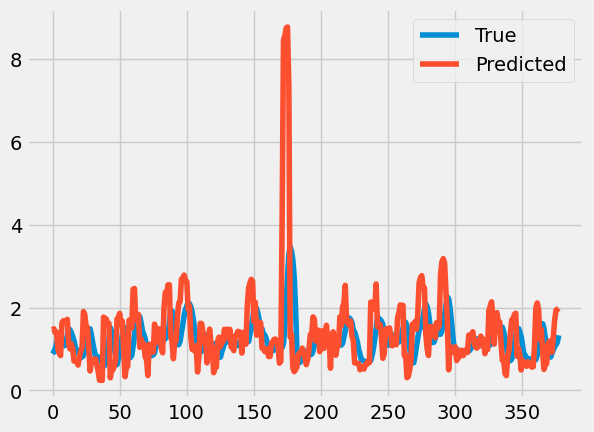

In [11]:
# We now define our LSTM model

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))
model.compile(loss='mse', optimizer='adam')

# We train the model
model.fit(feature_train, label_train, batch_size=512, epochs=5, validation_data = (feature_test, label_test))

# We make predictions
predicted_volatility = model.predict(feature_test)
plot_results(predicted_volatility,label_test)

# We compute the error
lstm_mse_error = mean_squared_error(label_test, predicted_volatility)
lstm_mae_error = mean_absolute_error(label_test, predicted_volatility)

n_zeros = dataset.shape[0] - predicted_volatility.shape[0]
dummy = np.concatenate([np.zeros(n_zeros), predicted_volatility.flatten()])

# Finally we store the data in out dataset
dataset['lstm_prediction'] = dummy

# GRU

Epoch 1/5


/Users/ahmikvirani/.pyenv/versions/3.11.5/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 2.6879 - val_loss: 0.7778
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7253 - val_loss: 0.9688
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.8279 - val_loss: 0.6927
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.7675 - val_loss: 0.6739
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.6806 - val_loss: 0.6456
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


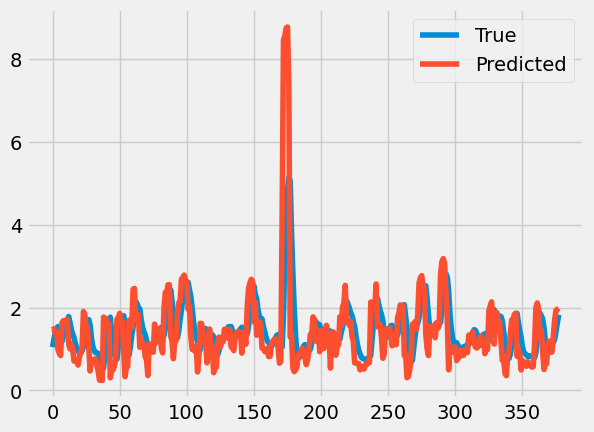

In [12]:
# We now define our GRU model

model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(GRU(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')

# We train the model
model.fit(feature_train, label_train, batch_size=512, epochs=5, validation_data = (feature_test, label_test))

# We make predictions
predicted_volatility = model.predict(feature_test)
plot_results(predicted_volatility,label_test)

gru_mse_error = mean_squared_error(label_test, predicted_volatility)
gru_mae_error = mean_absolute_error(label_test, predicted_volatility)

n_zeros = dataset.shape[0] - predicted_volatility.shape[0]
dummy = np.concatenate([np.zeros(n_zeros), predicted_volatility.flatten()])

# We store in our dataset
dataset['gru_prediction'] = dummy

# RNN

Epoch 1/5


/Users/ahmikvirani/.pyenv/versions/3.11.5/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 1.6203 - val_loss: 0.6857
Epoch 2/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0504 - val_loss: 0.8435
Epoch 3/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7778 - val_loss: 0.5350
Epoch 4/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6261 - val_loss: 0.5107
Epoch 5/5
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5525 - val_loss: 0.4255
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


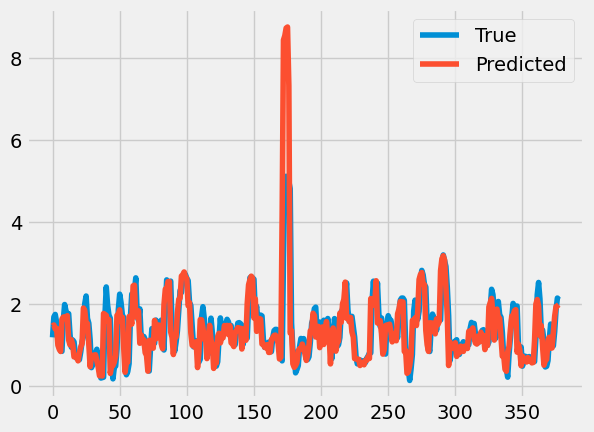

In [13]:
# We now define our RNN model

model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')

# We train the model
model.fit(feature_train, label_train, batch_size=512, epochs=5, validation_data = (feature_test, label_test))

# We make predictions
predicted_volatility = model.predict(feature_test)
plot_results(predicted_volatility,label_test)

# We compute the error
rnn_mse_error = mean_squared_error(label_test, predicted_volatility)
rnn_mae_error = mean_absolute_error(label_test, predicted_volatility)

n_zeros = dataset.shape[0] - predicted_volatility.shape[0]
dummy = np.concatenate([np.zeros(n_zeros), predicted_volatility.flatten()])

# We add to the dataset
dataset['rnn_prediction'] = dummy

## We next take the options data

In [14]:
# Collect the options data
options_data = pd.read_csv('OPTSTK_SBIN_CE_01-Apr-2024_TO_30-Jun-2024.csv')
options_data['Date  '] = pd.to_datetime(options_data['Date  '])
options_data['Expiry  '] = pd.to_datetime(options_data['Expiry  '])
options_data = options_data.sort_values('Date  ').reset_index(drop=True)

In [15]:
# In our example we assume constant rate of interest
r = 6.5

In [16]:
# We extract the necessary Black Scholes Parameters

options_data['Time_to_expiry'] = ((options_data['Expiry  '] - options_data['Date  ']).dt.days) / 365
options_data['Stock_Price'] = dataset.loc[options_data['Date  ']]['Close'].values
options_data['Stock_Price_T'] = dataset.loc[options_data['Expiry  ']]['Close'].values

# We further add the volatility predictions of our various models
options_data['gru_volatility'] = dataset.loc[options_data['Date  ']]['gru_prediction'].values
options_data['lstm_volatility'] = dataset.loc[options_data['Date  ']]['lstm_prediction'].values
options_data['garch_volatility'] = dataset.loc[options_data['Date  ']]['garch_prediction'].values
options_data['rnn_volatility'] = dataset.loc[options_data['Date  ']]['rnn_prediction'].values

In [17]:
# We ensure that it is normalized

scaler = MinMaxScaler()
options_data['gru_volatility'] = scaler.fit_transform(options_data[['gru_volatility']])
options_data['lstm_volatility'] = scaler.fit_transform(options_data[['lstm_volatility']])
options_data['garch_volatility'] = scaler.fit_transform(options_data[['garch_volatility']])
options_data['rnn_volatility'] = scaler.fit_transform(options_data[['rnn_volatility']])

In [18]:
# We run the black scholes on the various data and predicted volatilities

black_scholes_values_gru, black_scholes_values_lstm, black_scholes_values_rnn, black_scholes_values_garch = [], [], [], []
for i in range(len(options_data)):
  black_scholes_values_gru.append(black_scholes(options_data['Time_to_expiry'][i], options_data['Stock_Price'][i], options_data['Strike Price  '][i], r/100, (options_data['gru_volatility'][i])))
  black_scholes_values_lstm.append(black_scholes(options_data['Time_to_expiry'][i], options_data['Stock_Price'][i], options_data['Strike Price  '][i], r/100, (options_data['lstm_volatility'][i])))
  black_scholes_values_rnn.append(black_scholes(options_data['Time_to_expiry'][i], options_data['Stock_Price'][i], options_data['Strike Price  '][i], r/100, (options_data['rnn_volatility'][i])))
  black_scholes_values_garch.append(black_scholes(options_data['Time_to_expiry'][i], options_data['Stock_Price'][i], options_data['Strike Price  '][i], r/100, (options_data['garch_volatility'][i])))

/var/folders/mc/jb8s7cq1367dsr5fbqvwrdvm0000gn/T/ipykernel_58738/3230209470.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K) + (r + ((sigma**2)/2))*t) / (sigma * np.sqrt(t))


In [19]:
# We compue the profit and loss

options_data['p&l_gru'] = [
    max(stock_price_T - strike_price, 0) - close_price if bs_value > close_price else 0
    for stock_price_T, strike_price, close_price, bs_value in zip(
        options_data['Stock_Price_T'],
        options_data['Strike Price  '],
        options_data['Close  '],
        black_scholes_values_gru
    )
]

options_data['p&l_lstm'] = [
    max(stock_price_T - strike_price, 0) - close_price if bs_value > close_price else 0
    for stock_price_T, strike_price, close_price, bs_value in zip(
        options_data['Stock_Price_T'],
        options_data['Strike Price  '],
        options_data['Close  '],
        black_scholes_values_lstm
    )
]

options_data['p&l_rnn'] = [
    max(stock_price_T - strike_price, 0) - close_price if bs_value > close_price else 0
    for stock_price_T, strike_price, close_price, bs_value in zip(
        options_data['Stock_Price_T'],
        options_data['Strike Price  '],
        options_data['Close  '],
        black_scholes_values_rnn
    )
]

options_data['p&l_garch'] = [
    max(stock_price_T - strike_price, 0) - close_price if bs_value > close_price else 0
    for stock_price_T, strike_price, close_price, bs_value in zip(
        options_data['Stock_Price_T'],
        options_data['Strike Price  '],
        options_data['Close  '],
        black_scholes_values_garch
    )
]

options_data['if_always_bought'] = [
    max(stock_price_T - strike_price, 0) - close_price
    for stock_price_T, strike_price, close_price in zip(
        options_data['Stock_Price_T'],
        options_data['Strike Price  '],
        options_data['Close  ']
    )
]

In [20]:
# We try to capture the percentage of correct and incorrect trades we have made

p_l_gru, p_l_rnn, p_l_lstm, p_l_garch = 0, 0, 0, 0
successful_yes_gru, successful_no_gru, failure_yes_gru, failure_no_gru = 0,0,0,0
successful_yes_lstm, successful_no_lstm, failure_yes_lstm, failure_no_lstm = 0,0,0,0
successful_yes_rnn, successful_no_rnn, failure_yes_rnn, failure_no_rnn = 0,0,0,0
successful_yes_garch, successful_no_garch, failure_yes_garch, failure_no_garch = 0,0,0,0
cost_lstm, cost_gru, cost_rnn, cost_garch = 0,0,0,0

for i in range(len(options_data)):
  p_l_gru += options_data['p&l_gru'][i]
  p_l_lstm += options_data['p&l_lstm'][i]
  p_l_rnn += options_data['p&l_rnn'][i]
  p_l_garch += options_data['p&l_garch'][i]
  if(options_data['p&l_gru'][i] > 0):
    successful_yes_gru += 1
    cost_gru += options_data['Close  '][i]
  elif(options_data['p&l_gru'][i] < 0):
    failure_yes_gru += 1
    cost_gru += options_data['Close  '][i]
  elif(options_data['p&l_gru'][i] == 0 and options_data['if_always_bought'][i] > 0):
    failure_no_gru += 1
  elif(options_data['p&l_gru'][i] == 0 and options_data['if_always_bought'][i] < 0):
    successful_no_gru += 1

  if(options_data['p&l_lstm'][i] > 0):
    successful_yes_lstm += 1
    cost_lstm += options_data['Close  '][i]
  elif(options_data['p&l_lstm'][i] < 0):
    failure_yes_lstm += 1
    cost_lstm += options_data['Close  '][i]
  elif(options_data['p&l_lstm'][i] == 0 and options_data['if_always_bought'][i] > 0):
    failure_no_lstm += 1
  elif(options_data['p&l_lstm'][i] == 0 and options_data['if_always_bought'][i] < 0):
    successful_no_lstm += 1

  if(options_data['p&l_rnn'][i] > 0):
    successful_yes_rnn += 1
    cost_rnn += options_data['Close  '][i]
  elif(options_data['p&l_rnn'][i] < 0):
    failure_yes_rnn += 1
    cost_rnn += options_data['Close  '][i]
  elif(options_data['p&l_rnn'][i] == 0 and options_data['if_always_bought'][i] > 0):
    failure_no_rnn += 1
  elif(options_data['p&l_rnn'][i] == 0 and options_data['if_always_bought'][i] < 0):
    successful_no_rnn += 1

  if(options_data['p&l_garch'][i] > 0):
    successful_yes_garch += 1
    cost_garch += options_data['Close  '][i]
  elif(options_data['p&l_garch'][i] < 0):
    failure_yes_garch += 1
    cost_garch += options_data['Close  '][i]
  elif(options_data['p&l_garch'][i] == 0 and options_data['if_always_bought'][i] > 0):
    failure_no_garch += 1
  elif(options_data['p&l_garch'][i] == 0 and options_data['if_always_bought'][i] < 0):
    successful_no_garch += 1

## Here we showcase the results of the above experiments

In [21]:
print("---GARCH---:")
print(f"MAE error : {garch_mae_error}")
print(f"MSE error : {garch_mse_error}")
print(f'profit and loss : {p_l_garch}')
print(f'Total successful decisions made : {successful_yes_garch + successful_no_garch} : {successful_yes_garch} trades made and {successful_no_garch} decided to ignore')
print(f'Total unsuccessful decisions made : {failure_no_garch + failure_yes_garch} : {failure_yes_garch} trades with loss and {failure_no_garch} missed out on profit')
print(f'total trades made : {successful_yes_garch + successful_yes_garch}')

print(f'Percentage of correct decisions : {(successful_yes_garch +successful_no_garch) / (successful_yes_garch + successful_no_garch + failure_no_garch + failure_yes_garch) }')

print(f'Percentage profit : {(p_l_garch/cost_garch)*100}%')

print('\n\n')

---GARCH---:
MAE error : 0.6039806678717095
MSE error : 0.6239092907487548
profit and loss : 25168.00000000009
Total successful decisions made : 5313 : 1650 trades made and 3663 decided to ignore
Total unsuccessful decisions made : 2707 : 1169 trades with loss and 1538 missed out on profit
total trades made : 3300
Percentage of correct decisions : 0.6624688279301746
Percentage profit : 11.064909622795996%





In [22]:
print("---LSTM---:")
print(f"MAE error : {lstm_mae_error}")
print(f"MSE error : {lstm_mse_error}")
print(f'profit and loss : {p_l_lstm}')
print(f'Total successful decisions made : {successful_yes_lstm + successful_no_lstm} : {successful_yes_lstm} trades made and {successful_no_lstm} decided to ignore')
print(f'Total unsuccessful decisions made : {failure_no_lstm + failure_yes_lstm} : {failure_yes_lstm} trades with loss and {failure_no_lstm} missed out on profit')
print(f'total trades made : {successful_yes_lstm + successful_yes_lstm}')

print(f'Percentage of correct decisions : {(successful_yes_lstm +successful_no_lstm) / (successful_yes_lstm + successful_no_lstm + failure_no_lstm + failure_yes_lstm) }')

print(f'Percentage profit : {(p_l_lstm/cost_lstm)*100}%')

print('\n\n')

---LSTM---:
MAE error : 0.5609931485311654
MSE error : 0.9440644821394557
profit and loss : 22273.300000000087
Total successful decisions made : 4837 : 1853 trades made and 2984 decided to ignore
Total unsuccessful decisions made : 3183 : 1848 trades with loss and 1335 missed out on profit
total trades made : 3706
Percentage of correct decisions : 0.6031172069825437
Percentage profit : 8.861275934140293%





In [23]:
print("---GRU---:")
print(f"MAE error : {gru_mae_error}")
print(f"MSE error : {gru_mse_error}")
print(f'profit and loss : {p_l_gru}')
print(f'Total successful decisions made : {successful_yes_gru + successful_no_gru} : {successful_yes_gru} trades made and {successful_no_gru} decided to ignore')
print(f'Total unsuccessful decisions made : {failure_no_gru + failure_yes_gru} : {failure_yes_gru} trades with loss and {failure_no_gru} missed out on profit')
print(f'total trades made : {successful_yes_gru + successful_yes_gru}')

print(f'Percentage of correct decisions : {(successful_yes_gru +successful_no_gru) / (successful_yes_gru + successful_no_gru + failure_no_gru + failure_yes_gru) }')

print(f'Percentage profit : {(p_l_gru/cost_gru)*100}%')

print('\n\n')

---GRU---:
MAE error : 0.4829646766391098
MSE error : 0.645585027305113
profit and loss : 21423.350000000108
Total successful decisions made : 5015 : 1721 trades made and 3294 decided to ignore
Total unsuccessful decisions made : 3005 : 1538 trades with loss and 1467 missed out on profit
total trades made : 3442
Percentage of correct decisions : 0.6253117206982544
Percentage profit : 9.009434666474935%





In [24]:
print("---RNN---:")
print(f"MAE error : {rnn_mae_error}")
print(f"MSE error : {rnn_mse_error}")
print(f'profit and loss : {p_l_rnn}')
print(f'Total successful decisions made : {successful_yes_rnn + successful_no_rnn} : {successful_yes_rnn} trades made and {successful_no_rnn} decided to ignore')
print(f'Total unsuccessful decisions made : {failure_no_rnn + failure_yes_rnn} : {failure_yes_rnn} trades with loss and {failure_no_rnn} missed out on profit')
print(f'total trades made : {successful_yes_rnn + successful_yes_rnn}')

print(f'Percentage of correct decisions : {(successful_yes_rnn +successful_no_rnn) / (successful_yes_rnn + successful_no_rnn + failure_no_rnn + failure_yes_rnn) }')

print(f'Percentage profit : {(p_l_rnn/cost_rnn)*100}%')

print('\n\n')

---RNN---:
MAE error : 0.35868295037900594
MSE error : 0.42551668722597824
profit and loss : 36329.19999999986
Total successful decisions made : 5498 : 2126 trades made and 3372 decided to ignore
Total unsuccessful decisions made : 2522 : 1460 trades with loss and 1062 missed out on profit
total trades made : 4252
Percentage of correct decisions : 0.6855361596009975
Percentage profit : 14.485947862597701%





## CNN BiLSTM

In [25]:
# Ensure that no nan values are present, CNN cannot handle NaN values
dataset = dataset.dropna(subset=['volatility'])

In [26]:
# We require fixed length sequences for CNN
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        seq_x = sequences[i:end_ix]
        seq_y = sequences[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Define the parameters for shape of the input for CNN
n_steps_in, n_steps_out = 8, 1
data_values = dataset[['volatility']].values
X, y = split_sequences(data_values, n_steps_in, n_steps_out)

n_seq = 2
n_steps = int(n_steps_in / n_seq)

X = X.reshape((X.shape[0], n_seq, n_steps, 1))
y = y.reshape((y.shape[0], y.shape[1]))

# Split the training and tesing data for this simulation
X_train = X[:split_idx]
y_train = y[:split_idx]
X_test = X[split_idx:]
y_test = y[split_idx:]

# CNN bilstm model
model = Sequential()
model.add(Input(shape=(n_seq, n_steps, 1)))
model.add(TimeDistributed(Conv1D(filters=256, kernel_size=2, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2, padding='same')))
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2, padding='same')))
model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(50, activation='relu')))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mae')
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


# Make predictions
y_pred = model.predict(X_test)

# We need to ensure the final size of the model is is consistent with our original data, this we need to flatten
def flatten(arr):
    return [item for sublist in arr for item in sublist]

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 2, 3, 256)      │           768 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 2, 2, 256)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 2, 1, 128)      │        65,664 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 2, 1, 128)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 2, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 2, 256)         │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │       122,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 452,501 (1.73 MB)

 Trainable params: 452,501 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 1.0798 - val_loss: 0.4315
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.4818 - val_loss: 0.3257
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.4414 - val_loss: 0.3134
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.4160 - val_loss: 0.3034
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.4123 - val_loss: 0.3185
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4031 - val_loss: 0.3136
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4165 - val_loss: 0.3384
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4068 - val_loss: 0.2888
Epoch 9/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3952 - val_loss: 0.2797
Epoch 10/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4031 - val_loss: 0.2854
Epoch 11/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3765 - val_loss: 0.3148
Epoch 12/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 

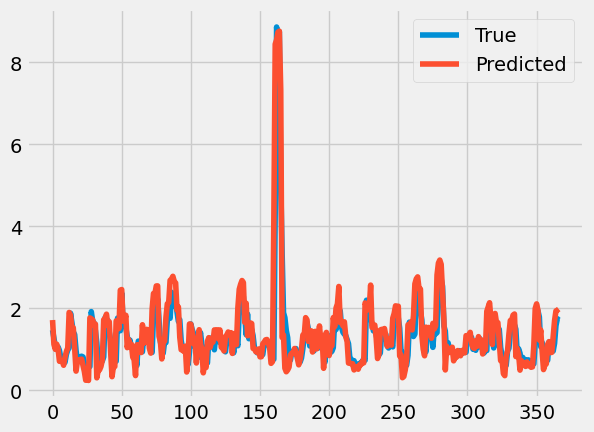

In [27]:
plot_results(y_pred,y_test)

# Compute the error
paper_mse_error = mean_squared_error(y_test, y_pred)
paper_mae_error = mean_absolute_error(y_test, y_pred)

n_zeros = dataset.shape[0] - y_pred.shape[0]
dummy = np.concatenate([np.zeros(n_zeros), y_pred.flatten()])

dataset['paper_prediction'] = dummy

# Store the predictions in the dataset
options_data['paper_volatility'] = dataset.loc[options_data['Date  ']]['paper_prediction'].values

In [28]:
scaler = MinMaxScaler()

# Ensure scaling before sending to black scholes
options_data['paper_volatility'] = scaler.fit_transform(options_data[['paper_volatility']])

In [29]:
# Compute black scholes predictions for this volatility

black_scholes_values_paper = []
for i in range(len(options_data)):
  black_scholes_values_paper.append(black_scholes(options_data['Time_to_expiry'][i], options_data['Stock_Price'][i], options_data['Strike Price  '][i], r/100, (options_data['paper_volatility'][i]/np.sqrt(365))))

/var/folders/mc/jb8s7cq1367dsr5fbqvwrdvm0000gn/T/ipykernel_58738/3230209470.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K) + (r + ((sigma**2)/2))*t) / (sigma * np.sqrt(t))


In [30]:
# Compute profit and loss

options_data['p&l_paper'] = [
    max(stock_price_T - strike_price, 0) - close_price if bs_value > close_price else 0
    for stock_price_T, strike_price, close_price, bs_value in zip(
        options_data['Stock_Price_T'],
        options_data['Strike Price  '],
        options_data['Close  '],
        black_scholes_values_paper
    )
]

In [31]:
# Find percentage of successful decisions made

p_l_paper = 0
cost_paper=0
successful_yes_paper, successful_no_paper, failure_yes_paper, failure_no_paper = 0,0,0,0
ctr=0
for i in range(len(options_data)):
  ctr+=1
  p_l_paper += options_data['p&l_paper'][i]

  if(options_data['p&l_paper'][i] > 0):
    successful_yes_paper += 1
    cost_paper += options_data['Close  '][i]
  elif(options_data['p&l_paper'][i] < 0):
    failure_yes_paper += 1
    cost_paper += options_data['Close  '][i]
  elif(options_data['p&l_paper'][i] == 0 and options_data['if_always_bought'][i] > 0):
    failure_no_paper += 1
  elif(options_data['p&l_paper'][i] == 0 and options_data['if_always_bought'][i] < 0):
    successful_no_paper += 1

## Here we showcase the final results of CNN BiLSTM approach

In [32]:
print("---CNN BiLSTM---:")
print(f"MAE error : {paper_mae_error}")
print(f"MSE error : {paper_mse_error}")
print(f'profit and loss : {p_l_paper}')
print(f'Total successful decisions made : {successful_yes_paper + successful_no_paper} : {successful_yes_paper} trades made and {successful_no_paper} decided to ignore')
print(f'Total unsuccessful decisions made : {failure_no_paper + failure_yes_paper} : {failure_yes_paper} trades with loss and {failure_no_paper} missed out on profit')
print(f'total trades made : {successful_yes_paper + successful_yes_paper}')

print(f'Percentage of correct decisions : {(successful_yes_paper +successful_no_paper) / (successful_yes_paper + successful_no_paper + failure_no_paper + failure_yes_paper) }')

print(f'Percentage profit : {(p_l_paper/cost_paper)*100}%')

print('\n\n')

---CNN BiLSTM---:
MAE error : 0.2867804843315865
MSE error : 0.2332228031833953
profit and loss : 36332.350000000006
Total successful decisions made : 6014 : 1448 trades made and 4566 decided to ignore
Total unsuccessful decisions made : 2006 : 266 trades with loss and 1740 missed out on profit
total trades made : 2896
Percentage of correct decisions : 0.7498753117206982
Percentage profit : 19.916409116772893%



